# Experiment with extracting shape info from confocal images of fish embryos

In [1]:
from aicsimageio import AICSImage
import os 
import glob2 as glob
import numpy as np
from matplotlib import pyplot as plt
import plotly.graph_objects as go
from skimage.morphology import (erosion, dilation, opening, closing,  # noqa
                                white_tophat)
import plotly.express as px
from skimage import data
from skimage import filters
from skimage.segmentation import active_contour
import matplotlib.pyplot as plt
from skimage.measure import label, regionprops
from skimage.morphology import black_tophat, skeletonize, convex_hull_image 
from skimage.morphology import disk
import skimage
from matplotlib.pyplot import colorbar 
from matplotlib.pyplot import savefig
import scipy

save_path_depth = "/Users/nick/Dropbox (Cole Trapnell's Lab)/Nick/morphSeq/data/20230412/3D_depth/"
# make save directory
if not os.path.isdir(save_path_depth):
    os.makedirs(save_path_depth)
    

image_path_4x = "/Users/nick/Dropbox (Cole Trapnell's Lab)/Nick/morphSeq/data/20230112/RNA300_GFP_4x_wholeEmbryo.nd2"
imObject4x = AICSImage(image_path_4x)
res_array_4x = np.asarray(imObject4x.physical_pixel_sizes)

image_path_10x = "/Users/nick/Dropbox (Cole Trapnell's Lab)/Nick/morphSeq/data/20230112/RNA300_GFP_10x_wholeEmbryo.nd2"
imObject10x = AICSImage(image_path_10x)
res_array_10x = np.asarray(imObject10x.physical_pixel_sizes)

# # generate and save depth image
# n_time_points = imObject.dims["T"][0]

In [2]:
print(res_array_10x)
print(res_array_4x)

[20.          1.08619834  1.08619834]
[12.5   2.75  2.75]


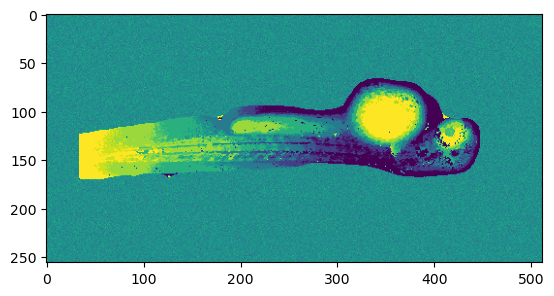

In [3]:
from skimage.measure import label, regionprops, regionprops_table

scale_x = 512
scale_y = 256

### resample to obtain desired pixel resoultion
target_res = 7 # um per pixel


# process 10x first
rs_vector10 = res_array_10x / target_res
rs_inv = np.floor(rs_vector10**(-1)).astype(int)
rs_inv[0] = 1
rs_vector2 = np.multiply(rs_inv, rs_vector10)

# extract image
imData = np.squeeze(imObject10x.data)

# Step 1: block reduction. Essentially max pooling
imData_block = skimage.measure.block_reduce(imData, (rs_inv[0], rs_inv[1], rs_inv[2]), np.max)

# Step 2: rescale so that voxels are isotropic
imData_rs = scipy.ndimage.zoom(imData_block, rs_vector2)

# Step 3: find brightest Z pixels at each xy coordinate
max_z_b = np.argmax(imData_rs, 0)
max_b_z = np.max(imData_rs, 0) # and brightest pixel values

# Step 4: mask
threshold_sa = filters.threshold_sauvola(max_b_z, window_size=9)
fish_mask = (max_b_z < threshold_sa)*1 
fp = disk(10)
fish_closed = closing(fish_mask, fp) # morphological closing
fp_small = disk(5)
fish_strip = skimage.morphology.remove_small_objects(label(fish_closed), min_size=600) # remove small objects
fish_clean = skimage.morphology.binary_erosion(fish_strip, fp_small) # clean up edges
fish_clean = scipy.ndimage.binary_fill_holes(fish_clean)
plt.imshow(fish_clean)

# step 5: Normalize
mean_z = np.mean(max_z_b[np.where(fish_clean==1)])
std_z = np.std(max_z_b[np.where(fish_clean==1)])

im_norm = -(max_z_b-mean_z)/std_z

size_x = 512
size_y = 256

# step 6: use mask to replace background pixels with white noise
im_norm[np.where(fish_clean==0)] = np.random.normal(loc=0, scale=.1, size=(np.sum(fish_clean==0),))

# Step 7: resize and center image
regions = regionprops(label(fish_clean))
im_center = regions[0].centroid
im_centroid = np.round(im_center).astype(int)

im_array10 = np.random.normal(loc=0, scale=.1, size=(size_y, size_x)) # initialize array

xmin = max(im_centroid[1]-(size_x/2),0)
xmax = min(xmin+size_x, fish_clean.shape[1])
from_x = np.arange(xmin, xmax).astype(int)

ymin = max(im_centroid[0]-(size_y/2),0)
ymax = min(xmin+size_y, fish_clean.shape[0])
from_y = np.arange(ymin, ymax).astype(int)

c_diff_y = size_y/2 - im_center[0] + 0.5
c_diff_x = size_x/2 - im_center[1] + 0.5

to_y = np.round(from_y + c_diff_y).astype(int)
to_x = np.round(from_x + c_diff_x).astype(int)

im_array10[to_y[0]:to_y[-1], to_x[0]:to_x[-1]] = im_norm[from_y[0]:from_y[-1], from_x[0]:from_x[-1]]

im_array10[np.where(np.abs(im_array10)>1)] = 1*np.sign(im_array10[np.where(np.abs(im_array10)>1)])
plt.imshow(im_array10)

# Next, test 4x

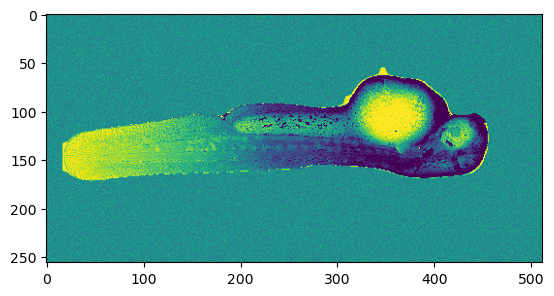

In [4]:
rs_vector4 = res_array_4x / target_res
rs_inv = np.floor(rs_vector4**(-1)).astype(int)
rs_inv[0] = 1
rs_vector2 = np.multiply(rs_inv, rs_vector4)

# extract image
imData = np.squeeze(imObject4x.data)

# Step 1: block reduction. Essentially max pooling
imData_block = skimage.measure.block_reduce(imData, (rs_inv[0], rs_inv[1], rs_inv[2]), np.max)

# Step 2: rescale so that voxels are isotropic
imData_rs = scipy.ndimage.zoom(imData_block, rs_vector2)

# Step 3: find brightest Z pixels at each xy coordinate
max_z_b = np.argmax(imData_rs, 0)
max_b_z = np.max(imData_rs, 0) # and brightest pixel values

# Step 4: mask
threshold_sa = filters.threshold_sauvola(max_b_z, window_size=9)
fish_mask = (max_b_z < threshold_sa)*1 
fp = disk(5)
fish_closed = closing(fish_mask, fp) # morphological closing
fp_small = disk(3)
fish_strip = skimage.morphology.remove_small_objects(label(fish_closed), min_size=600) # remove small objects
fish_clean = skimage.morphology.binary_erosion(fish_strip, fp_small) # clean up edges
fish_clean = scipy.ndimage.binary_fill_holes(fish_clean)
# plt.imshow(fish_clean)

# step 5: Normalize
mean_z = np.mean(max_z_b[np.where(fish_clean==1)])
std_z = np.std(max_z_b[np.where(fish_clean==1)])

im_norm = -(max_z_b-mean_z)/std_z

size_x = 512
size_y = 256

# step 6: use mask to replace background pixels with white noise
im_norm[np.where(fish_clean==0)] = np.random.normal(loc=0, scale=.1, size=(np.sum(fish_clean==0),))

# Step 7: resize and center image
regions = regionprops(label(fish_clean))
im_center = regions[0].centroid
im_centroid = np.round(im_center).astype(int)

im_array4 = np.random.normal(loc=0, scale=.1, size=(size_y, size_x)) # initialize array

xmin = max(im_centroid[1]-(size_x/2),0)
xmax = min(xmin+size_x, fish_clean.shape[1])
from_x = np.arange(xmin, xmax).astype(int)

ymin = max(im_centroid[0]-(size_y/2),0)
ymax = min(xmin+size_y, fish_clean.shape[0])
from_y = np.arange(ymin, ymax).astype(int)

c_diff_y = size_y/2 - im_center[0] + 0.5
c_diff_x = size_x/2 - im_center[1] + 0.5

to_y = np.round(from_y + c_diff_y).astype(int)
to_x = np.round(from_x + c_diff_x).astype(int)

im_array4[to_y[0]:to_y[-1], to_x[0]:to_x[-1]] = im_norm[from_y[0]:from_y[-1], from_x[0]:from_x[-1]]

im_array4[np.where(np.abs(im_array4)>1)] = 1*np.sign(im_array4[np.where(np.abs(im_array4)>1)])
plt.imshow(im_array4)

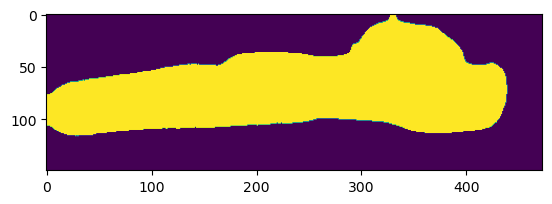

In [5]:
fp = disk(5)
fish_closed = closing(fish_mask, fp) # morphological closing
fp_small = disk(3)
fish_strip = skimage.morphology.remove_small_objects(label(fish_closed), min_size=600) # remove small objects
fish_clean = skimage.morphology.binary_erosion(fish_strip, fp_small) # clean up edges
fish_clean = scipy.ndimage.binary_fill_holes(fish_clean)
plt.imshow(fish_clean)

In [6]:
imData10 = np.squeeze(imObject10x.data)
print(imData10.shape)
imData4 = np.squeeze(imObject4x.data)
print(imData4.shape)
print(imData.shape)

(24, 900, 3036)
(60, 380, 1203)
(60, 380, 1203)


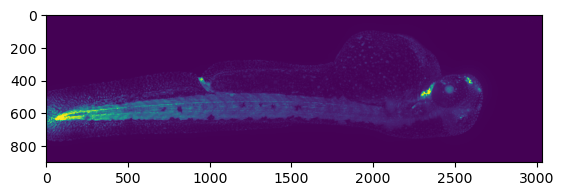

In [7]:
imMax4 = np.max(imData4, axis=0)
imMax10 = np.max(imData10, axis=0)
plt.imshow(imMax10)

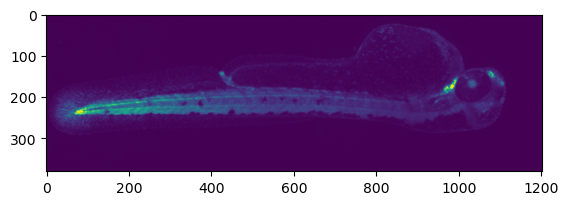

In [8]:
plt.imshow(imMax4)